In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os
import matplotlib.pyplot as pl
import json
plotrcfile = os.getenv("PUIDATA") + "/" + os.getenv("USER") + "_matplotlibrc.json"
plotrc = json.load(open(plotrcfile))
pl.rcParams.update(plotrc)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load the primary data source of MTA fare swipes. Will initially try working from a Pandas Panel.

In [2]:
fil = os.getenv("PUIDATA") + "/MTA_Fare.npy"
np_fares = np.load(fil)
# np.nan exists only for type float, so need to recast the array in order
# to assign the invalid cells to NaN AND have it behave as it should.
np_fares = np_fares.astype(float)
np_fares[np_fares == -1] = np.nan

Many of the cells in the array have no data, represented by a value of -1. If this is unaccounted for when adding up across an axis, it could distort the results. In order to address this, any cell with a value of -1 will be set to NaN. This is done by looping through each item of the Panel and then each column of the item (major axis) and using the Pandas function to set everything equals -1 to np.nan

In [3]:
np_fares.shape

(600, 23, 194)

In [4]:
# Create a list of dates by week
weeks = pd.date_range('5/21/2010', periods=194, freq='W-FRI')

# Create a list of fare types. All of the items are valid for use as
# DataFrame.<colid>
rtypes = np.array(['r10t', 'u14d', 'u1d', 'r2t', 'u30d', 'u7d', 'ada',
                   'afas', 'exp', 'ez', 'ff', 'mc', 'mr', 'month', 'rfm', 'rr',
                   'sen', 'spec', 'tcmc', 'tkt', 'unl', 'xbus', 'student'])

# Description of each fare type to use in the legends
typedescs = {'r10t' : '10 Trip', 'u14d' : '14 Day', 'u1d' : '1 Day/Fun',
             'r2t' : '2 Trip', 'u30d' : '30 Day', 'u7d' : '7 Day', 'ada' : "Amer. w/ Dis.",
             'afas' : 'ADA Farecard', 'exp' : 'Express', 'ez' : 'Easy Pay',
             'ff' : 'Full Fare', 'mc' : 'Metrocard', 'mr' : "Mail&Ride",
             'month' : 'Monthly', 'rfm' : 'Reduced Fare', 'rr' : 'Rail Road',
             'sen' : 'Sen. Cit./Dis.', 'spec' : 'Special', 'tcmc' : "Trans Chk",
             'tkt' : 'Ticket', 'unl' : 'Unlimited', 'xbus' : 'Express Bus', 'student' : 'Student'}

In [5]:
fares = pd.Panel(np_fares, major_axis=rtypes, minor_axis=weeks)
fares.describe

<bound method Panel.describe of <class 'pandas.core.panel.Panel'>
Dimensions: 600 (items) x 23 (major_axis) x 194 (minor_axis)
Items axis: 0 to 599
Major_axis axis: r10t to student
Minor_axis axis: 2010-05-21 00:00:00 to 2014-01-31 00:00:00>

In [6]:
fares[0].columns

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23',
               ...
               '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
               '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
               '2014-01-24', '2014-01-31'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

In [7]:
# Take a look at the axes of the Panel to see the headings
fares.axes

[RangeIndex(start=0, stop=600, step=1),
 Index([u'r10t', u'u14d', u'u1d', u'r2t', u'u30d', u'u7d', u'ada', u'afas',
        u'exp', u'ez', u'ff', u'mc', u'mr', u'month', u'rfm', u'rr', u'sen',
        u'spec', u'tcmc', u'tkt', u'unl', u'xbus', u'student'],
       dtype='object'),
 DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
                '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
                '2010-07-16', '2010-07-23',
                ...
                '2013-11-29', '2013-12-06', '2013-12-13', '2013-12-20',
                '2013-12-27', '2014-01-03', '2014-01-10', '2014-01-17',
                '2014-01-24', '2014-01-31'],
               dtype='datetime64[ns]', length=194, freq='W-FRI')]

Collapse the data by station and by fare type. This will create two DataFrames indexed by week, one with columns of stations and one with columns of fare types.

In [8]:
# Add up the rides for each ride type (major axis).
# Returns a DataFrame with columns of stations and rows of weeks (index)
coll_sta = fares.sum(axis=1, skipna=True)
coll_sta.shape

(194, 600)

In [9]:
coll_sta.head(3)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
2010-05-21,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-28,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-04,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table 1-1. The total rides by station for the first three weeks.

In [10]:
# Add up the rides for each station (items).
# Return a DataFrame with columns of weeks and rows of ride types.
# Then transpose it for rows of weeks (index) and columns of ride types.
coll_types = fares.sum(axis=0, skipna=True).transpose()
coll_types.shape

(194, 23)

In [11]:
coll_types.head(3)

,r10t,u14d,u1d,r2t,u30d,u7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,tkt,unl,xbus,student
2010-05-21,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,NaN
2010-05-28,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,NaN
2010-06-04,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,NaN


Table 1-2. The total rides by fare type for the first three weeks.

In [12]:
# Verify that the two frames each add up to the same thing
print(coll_types.sum().sum())
coll_sta.sum().sum()

5777581875.0


5777581875.0

### Task 1
Detect the event that saw a $> 3\sigma$ drop in ridership.

First step is to collapse all the data to total by week. Divide by 1000 to put everything in a proper scale. Calculate the mean and standard deviation from this Series and plot, adding a dashed line to show mean, and 1 and 3 standard deviations off.

In [13]:
# Convert the DataFrame to a Series by summing across the rows.
# Either the station or rtype DataFrame should yield the same result.
collapse = coll_sta.sum(axis=1, skipna=True) / 1000
collapse.shape

(194,)

In [14]:
# These will be used to plot the mean and intervals
mean_rides = collapse.mean()
std_rides = collapse.std()

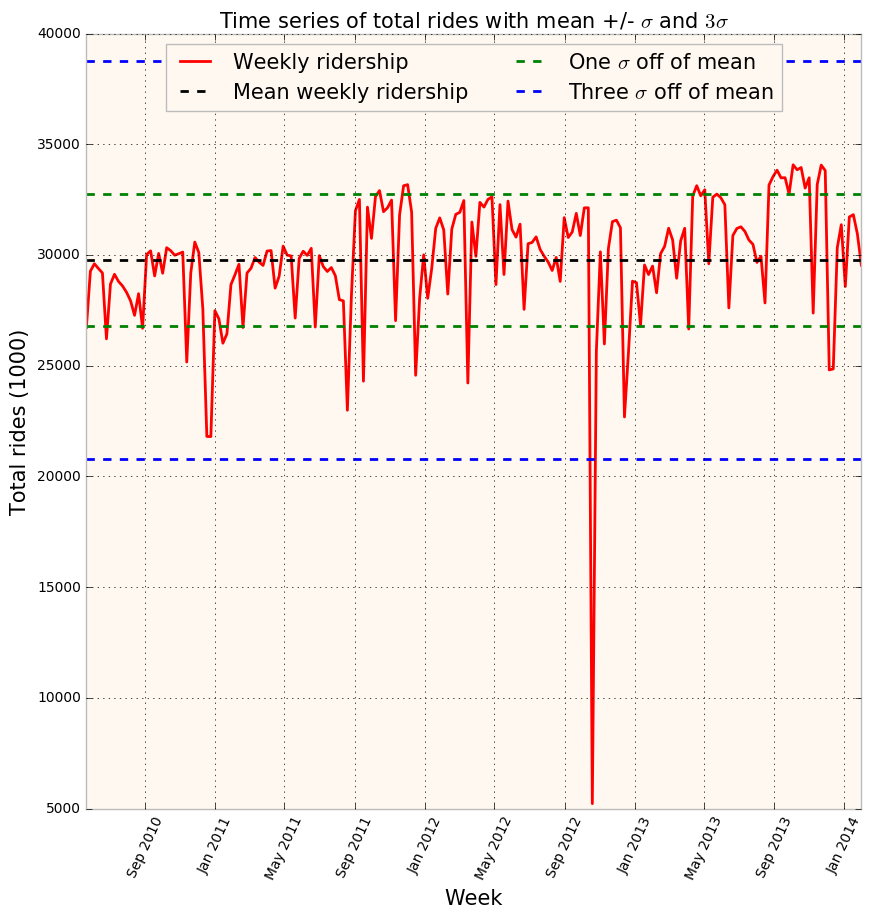

In [15]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# The index of the Series collapse contains the dates for each week in
# the time series. Make an array of the first and last date to allow
# plotting the mean and error intervals.
ser_start = collapse.index[0]
ser_end = collapse.index[-1]
ax.plot(collapse.index, collapse, "r-", label="Weekly ridership")
ser_st_en = [ser_start, ser_end]
ax.plot(ser_st_en, [mean_rides, mean_rides], "k--", label="Mean weekly ridership")
# Only add each color once to the legend
ax.plot([ser_start, ser_start], [mean_rides, mean_rides],
        "g--", label="One $\\sigma$ off of mean")
ax.plot([ser_start, ser_start], [mean_rides, mean_rides],
        "b--", label="Three $\\sigma$ off of mean")
# Add error interval above and below the mean
for fact in -1, 1:
    ax.plot(ser_st_en, [mean_rides + fact * std_rides, mean_rides + fact * std_rides], "g--")
    ax.plot(ser_st_en, [mean_rides + 3 * fact * std_rides,
                        mean_rides + 3 * fact * std_rides], "b--")
ax.set_title("Time series of total rides with mean +/- $\\sigma$ and $3\\sigma$", fontsize=15)
pl.ylabel("Total rides (1000)", fontsize=15)
pl.xlabel("Week", fontsize=15)
pl.xticks(rotation='65')
pl.legend(loc='upper center', ncol=2, fontsize=15)

Figure 1-1. Shows the variation of total ridership per week from May 2010 until February 2014. Includes a sharp drop sometime around October 2012 of roughly $7\sigma$ from the mean.

In [16]:
outliers = collapse.loc[collapse < 20000]
print(outliers)
print("Which is {:.3f} standard deviations less than the mean".
      format((mean_rides - outliers[outliers.index[0]]) / std_rides))

2012-10-19    5218.686
Freq: W-FRI, dtype: float64
Which is 8.210 standard deviations less than the mean


The week starting October 19, 2012 had a shutdown due to Hurricane Sandy. The system was shutdown the day before the storm and it took several days afterwards in order restore power to resume service.

### Task 2
Identify which ride types are stationary, which have gained in popularity and which have decreased.

In [17]:
# Start by plotting the ride types over time.
# However, the variation in usage of the different ride types is such that
# putting all of the ride type in one plot would not present well, so
# group the types by ranges of usage and make plots for types of similar usage levels.
# First step in doing so is to collate some summary statistics by each ride type.
rtmins  = coll_types.min(axis=0, skipna=True)
rtmaxes = coll_types.max(axis=0, skipna=True)
rtmeans = coll_types.mean(axis=0, skipna=True)
rtstds  = coll_types.std(axis=0, skipna=True)
rtsummary = pd.concat([rtmins, rtmaxes, rtmeans, rtstds], axis=1,
                      keys=['min', 'max', 'mean', 'std'])
rtsummary

,min,max,mean,std
r10t,2331726.0,15308307.0,1.324237e+07,1.215646e+06
u14d,106099.0,804458.0,6.279107e+05,9.086609e+04
u1d,10203.0,68550.0,5.631127e+04,7.618889e+03
r2t,34900.0,206860.0,1.872066e+05,1.763610e+04
u30d,1268.0,68555.0,4.855778e+04,1.266652e+04
u7d,1012882.0,6461735.0,4.794654e+06,7.650241e+05
ada,1562426.0,10145625.0,8.958481e+06,1.056175e+06
afas,0.0,12794.0,1.886149e+03,4.072470e+03
exp,0.0,364363.0,4.870894e+04,1.111608e+05
ez,0.0,769745.0,9.940767e+04,2.218770e+05


Table 2-1. Summary statistics for each of the ride types. Includes minimum, maximum, mean, and standard deviation. This is used as a first stab in grouping the ride types by usage level.

In [18]:
# Segment the ride types based on how often they're used
# Hi, Middle, and Lo are determined based on the mean of rides
# Middle is split based on the max. This is so that the larger group will have a
# narrower range which will allow each series to be spaced further apart.
hi_usage = rtsummary[rtsummary['mean'] > 1000000]
lo_usage = rtsummary[rtsummary['mean'] < 30000]
m1_usage = rtsummary[(rtsummary['mean'] >= 30000) & (rtsummary['mean'] < 1000000) &
                     (rtsummary['max'] < 350000)]
m2_usage = rtsummary[(rtsummary['mean'] >= 30000) & (rtsummary['mean'] < 1000000) &
                     (rtsummary['max'] >= 350000)]
for grp in hi_usage, m2_usage, m1_usage, lo_usage:
    print(grp.shape)

(3, 4)
(5, 4)
(9, 4)
(6, 4)


Define a procedure that will be used to plot time series for individual ride types. This allows
defining the recurrent parts of the plot once and calling it separately for each ride type with the information that changes.

In [19]:
color_seq = ['red', 'magenta', 'orange', 'yellow', 'blue', 'cyan', 'green', 'black', 'brown']
seqlen = len(color_seq)

def plot_rtype(rtype, scale, color):
    # rtype - Identifier for the type of ride
    # scale - Scaling factor so that values on the y-axis will not get too large
    # color - Color to use for the ride type
    pl.plot(coll_types.index, pd.stats.moments.rolling_mean(coll_types[rtype] / scale, 10),
            color=color, alpha = .7, label=typedescs[rtype])

Define another procedure to plot groups of ride types. This will be called once per cell and will thus generate separate plots and will pass the necessary information each group to plot_rtype

In [20]:
def plot_typegrp(grp, scale, labscale, gdesc):
    # grp      - The group of ride types, one of the DataFrames from [21]
    # scale    - Divide the number of rides by this factor
    # labscale - The scale factor to put in the y-label
    # gdesc    - A descriptor of the group to put in the title
    curr_col = 0
    pl.figure(figsize=(10, 4))
    pl.xlabel("Weeks")
    pl.ylabel("Swipes ({}s)".format(labscale))
    # Create limits for the x-axis that are somewhat larger than
    # the sample to create space for the legend
    limrange = pd.date_range('5/21/2010', periods=25, freq="10W")
    pl.xlim(limrange[0], limrange[-1])
    for typ in grp.index:
        plot_rtype(typ, scale, color_seq[curr_col])
        # Cycle through the colors in color_seq
        curr_col = (curr_col + 1) % seqlen
    pl.xticks(rotation='65')
    pl.legend(fontsize=10)
    pl.title("Rides by week for {} usage ride types".format(gdesc))

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


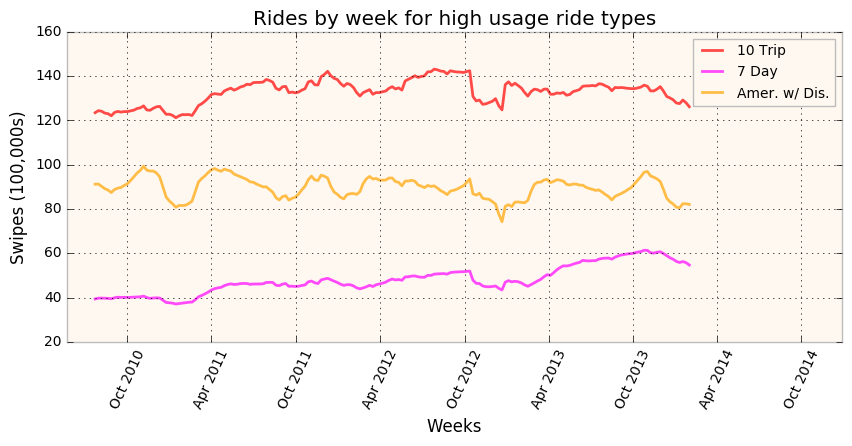

In [21]:
plot_typegrp(hi_usage, 100000, "100,000", 'high')

Figure 2-1. Time series for high usage ride types. The right edge of the plot is padded to allow space for the legend. This will be done for all of the ride type groups.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


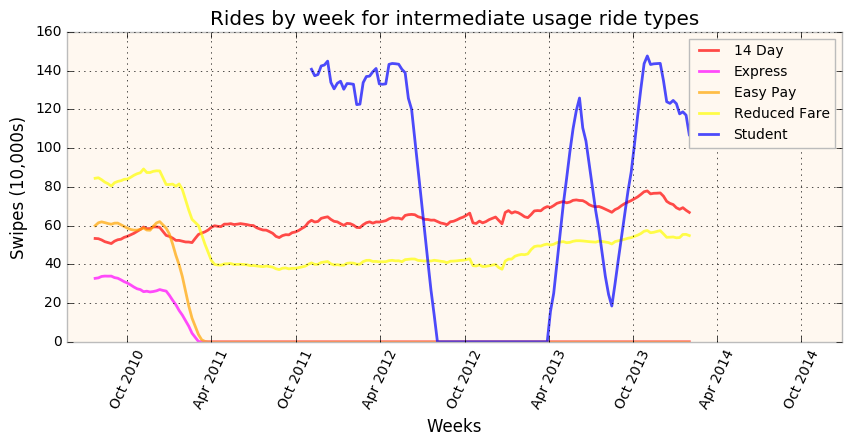

In [22]:
plot_typegrp(m2_usage, 10000, "10,000", 'intermediate')

Figure 2-2. Time series for hi-intermediate usage ride types.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


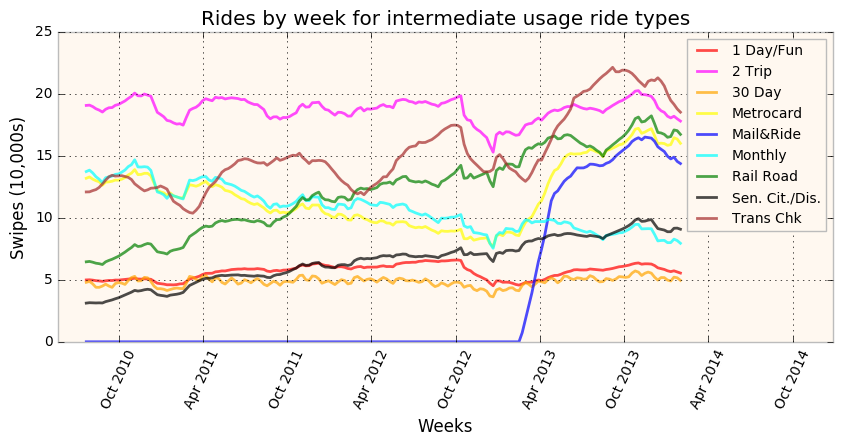

In [23]:
plot_typegrp(m1_usage, 10000, '10,000', 'intermediate')

Figure 2-3. Time series for lo-intermediate usage ride types.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


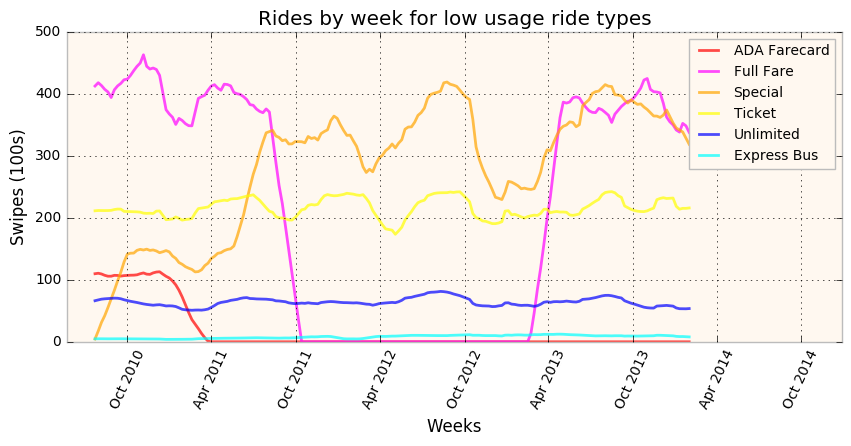

In [24]:
plot_typegrp(lo_usage, 100, 100, 'low')

Figure 2-4. Time series for low-usage ride types.

The following ride types apparently had a somewhat steady increase in usage: Special, Rail Road, Senior Citizen, Transit Check, 14-Day, 7-Day.

The following ride types apparently had a somewhat steady decrease in usage: Monthly.

Now to formally test that these ride types have a steady increase/decrease. Do so by comparing the average of the first 10 weeks to the middle 10 weeks and last 10 weeks.

In [25]:
# Create DataFrames that have only the first 10 weeks,
# the middle 10 weeks (92 to 102) and last 10 weeks
first_weeks = coll_types[coll_types.index < coll_types.index[10]]
mid_weeks = coll_types[(coll_types.index >= coll_types.index[92]) &
                       (coll_types.index < coll_types.index[102])]
last_weeks = coll_types[coll_types.index >= coll_types.index[-10]]
last_weeks.shape

(10, 23)

In [26]:
first_means = first_weeks[['spec', 'rr', 'sen', 'tcmc', 'u14d',
                           'u7d', 'month']].mean(axis=0, skipna=True)
mid_means = mid_weeks[['spec', 'rr', 'sen', 'tcmc', 'u14d',
                       'u7d', 'month']].mean(axis=0, skipna=True)
last_means = last_weeks[['spec', 'rr', 'sen', 'tcmc', 'u14d',
                         'u7d', 'month']].mean(axis=0, skipna=True)
rtype_means = pd.concat([first_means, mid_means, last_means], axis=1,
                        keys=['first', 'middle', 'last']).transpose()
rtype_means

,spec,rr,sen,tcmc,u14d,u7d,month
first,454.0,64516.0,31208.6,120860.6,533376.2,3934303.6,137296.4
middle,31910.7,127969.2,69506.8,133031.2,640696.7,4834331.4,112149.6
last,31862.8,167287.4,90798.2,185191.2,667821.7,5467689.0,79456.5


Table 2-1. Shows the average for the first 10 weeks, middle 10 weeks and last 10 weeks for the ride types of interest. The ride types Rail Road, Senior Citizen, Transit Check, 14-Day Unlimited, and 7-Day Unlimited show a clear increase for both time ranges, albeit less pronounced for middle to last for 14-Day Unlimited. The Monthly shows a steady decrease. The Special ride type had an increase from the first 10 to the middle 10, but roughly held steady from the middle 10 to the last 10. The greatest percentage increase was for Senior Citizen.

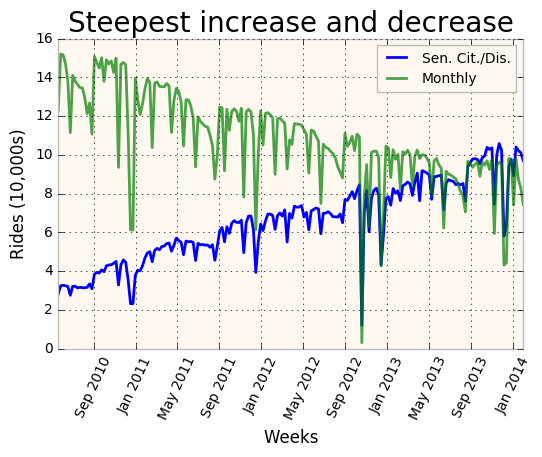

In [27]:
# Plot the ride type with the steepest percentage increase and the only one with a steady decrease
pl.plot(coll_types.index, coll_types.sen / 10000, "b-", label=typedescs['sen'])
pl.plot(coll_types.index, coll_types.month / 10000, "g-", label=typedescs['month'], alpha=0.7)
pl.xticks(rotation='65')
pl.ylabel("Rides (10,000s)")
pl.xlabel("Weeks")
pl.title("Steepest increase and decrease", fontsize=20)
pl.legend(loc='best')

Figure 2-5. Shows the increase in usage of the Senior Citizen/Disabled fare type along with the decline in the usage of the monthly fare.

## Task 3
Identify what stations have an annual periodicity.

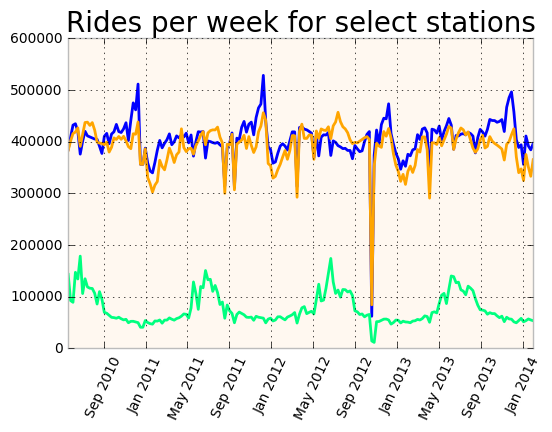

In [28]:
# Eyeball a few stations to find periodic behavior
pl.plot(coll_sta.index, coll_sta[21], "b-")
pl.plot(coll_sta.index, coll_sta[32], color="orange")
pl.plot(coll_sta.index, coll_sta[150], color='springgreen')
pl.xticks(rotation='65')
pl.title("Rides per week for select stations", fontsize=20)

Figure 3-1. A view of the time series of three stations that seem to have periodic behavior. It happens to be stations 21, 32, and 150.

In [29]:
# Use np.fft.rfft to obtain the power spectrum for each station
# Based on examining the power spectra from stations that showed clear
# periodic behavior, the first item in the list is a spike, so it will
# have to be ignored. Otherwise, item 4 showed a minor spike for
# station 32 and a major one for station 150. Thus, periodic behavior
# will be identified by a spike at item 4.
periodicity_list = []
for stano in coll_sta.columns:
    fftEx = np.abs(np.fft.rfft(coll_sta[stano]))
    spike = fftEx[4] / max(max(fftEx[1:3]), max(fftEx[5:20]))
    if spike > 1.5:
        periodicity_list.append(stano)
periodicity_list

[32, 51, 150, 186, 194, 280, 311, 327, 462, 545, 550]

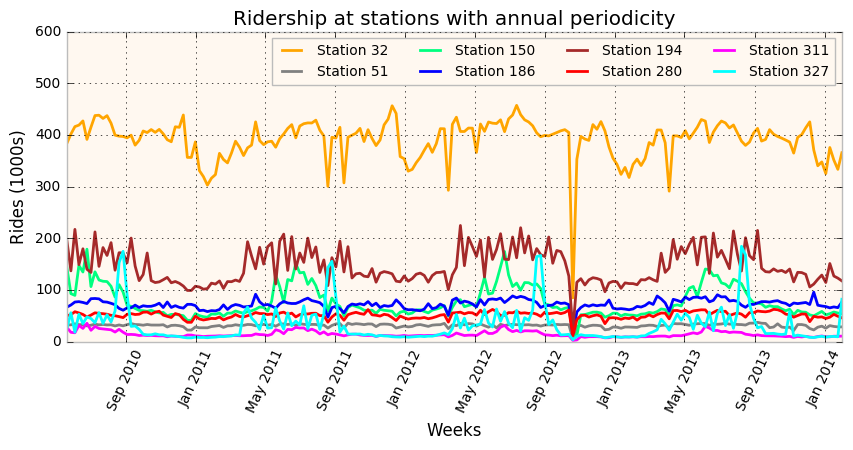

In [30]:
# Plot the ridership at the stations identified above
# Will further refine the list
#stFig, (stAx, stAx2) = pl.subplots(2, 1, sharex=True, figsize=(10, 8))
#stAx = stFig.add_subplot(211)
fig = pl.figure(figsize=(10, 4))
sta_color_list = 'orange,grey,springgreen,blue,brown,red,magenta,cyan'.split(',')
curr_color = 0
pl.title("Ridership at stations with annual periodicity")
for stano in periodicity_list[:8]:
    pl.plot(coll_sta.index, coll_sta[stano] / 1000, "-",
            color=sta_color_list[curr_color], label="Station {}".format(stano))
    curr_color += 1
pl.xticks(rotation='65')
pl.ylabel("Rides (1000s)")
pl.xlabel("Weeks")
pl.ylim(0, 600)
pl.legend(loc='best', ncol=4, fontsize=10)

Figure 3-2(a). Plot of the timeseries of the first eight stations that exhibited possible annual periodicity based on the power spectrum. From these, stations 32, 150, 194, and 327 look the most periodic, showing peak usage between May and August. A possible reason for such behavior would be stations that have summer attractions, such as beach locations or Willetts Point/Citi Field.

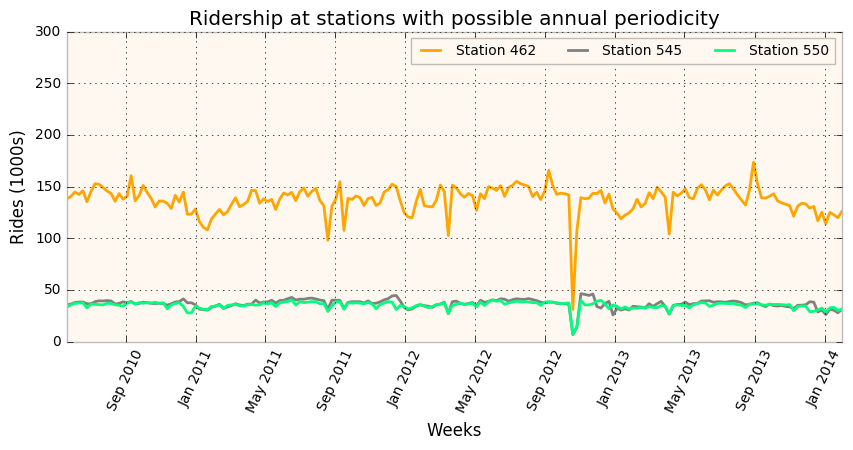

In [31]:
curr_color = 0
#stAx2 = stFig.add_subplot(212)
# Split into two plots for better readability
fig = pl.figure(figsize=(10, 4))
for stano in periodicity_list[8:]:
    pl.plot(coll_sta.index, coll_sta[stano] / 1000, "-", color=sta_color_list[curr_color],
              label="Station {}".format(stano))
    curr_color += 1
pl.xticks(rotation='65')
pl.ylabel("Rides (1000s)")
pl.xlabel("Weeks")
pl.ylim((0, 300))
pl.title("Ridership at stations with possible annual periodicity")
pl.legend(loc='best', ncol=4, fontsize=10)

Figure 3-2(b). The time series for the remaining stations possibly showing periodicity. None of these seem to have an annual pattern.

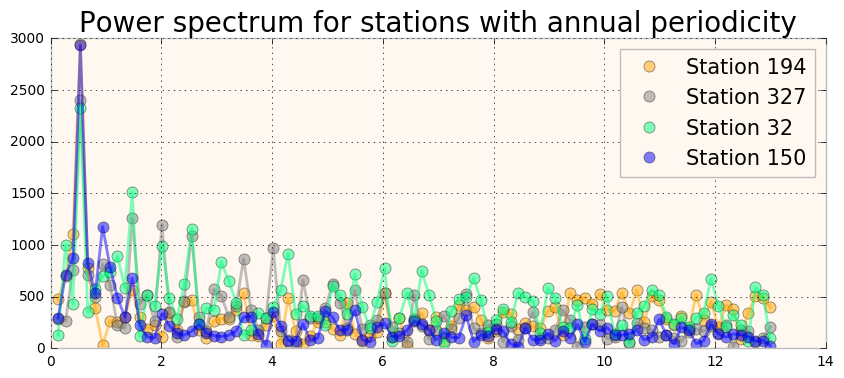

In [32]:
# Plot the power spectra for the stations identified above
# Start with creating the frequency array for the x-axis
# Use a sample rate of 1 / 26 to get half-years. This should
# lead to a spike at 0.5
freq = np.fft.rfftfreq(len(coll_sta.index), 1.0 / 26.0)
fftFig = pl.figure(figsize=(10, 4))
fftAx = fftFig.add_subplot(111)
# Generate and plot the power spectrum for each station in the list
curr_color = 0
for stano in 194, 327, 32, 150:
    fftEx = np.abs(np.fft.rfft(coll_sta[stano])) / 1000
    fftAx.plot(freq[1:], fftEx[1:], "o", ms=8, alpha=0.5,
               label="Station {}".format(stano), color=sta_color_list[curr_color])
    fftAx.plot(freq[1:], fftEx[1:], "-", color=sta_color_list[curr_color], alpha=0.5)
    curr_color += 1
pl.title("Power spectrum for stations with annual periodicity", fontsize=20)
pl.legend(loc='best', fontsize=15, numpoints=1)

Figure 3-3. Power spectra for stations 32, 150, 194, 327. Each of the four stations has a peak at 0.5. Stations 32 and 327 have lesser peaks subsequently, albeit none greater than 2/3 of the overall peak.